In [1]:
import numpy as np
import pandas as pd
import pickle
import polars as pl
import seaborn as sns
from tqdm.auto import tqdm
import math
import scipy.stats as stats
from itertools import combinations
import matplotlib.pyplot as plt

/home/tunajaw/anaconda3/envs/TEE4EHR/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# ctd data

with open('../dataset/event/split0/idcode_ccs.pkl', 'rb') as f:
    ccs_data = pickle.load(f, encoding='latin-1')

with open('../dataset/event/split0/idcode_exam.pkl', 'rb') as f:
    exam_data = pickle.load(f, encoding='latin-1')

with open('../dataset/event/split0/idcode_map.pkl', 'rb') as f:
    idcode_map = pickle.load(f, encoding='latin-1')

ccs_name = pd.read_csv('../dataset/event/analysis/ccs_sheet.csv')['ccs_name']
ccs_map = {ccs: i for i, ccs in enumerate(ccs_name)}

cx_name = ['None'] + pd.read_csv('../dataset/event/analysis/severe-diagnosis.csv')['Comorbidities'].to_list()

In [3]:
cx_name

['None',
 'interstitial lung disease',
 'Renal compromise',
 'Malignancy of lung',
 'PAH',
 'Lymphoma',
 'Thrombocytopenia']

In [7]:
# model output

x_corpus = np.load('../temp_model/[event_mc_sup--TEDA__pp_single_mark-concat]/data/x_corpus.npz')['arr_0']
idcode = np.load('../temp_model/[event_mc_sup--TEDA__pp_single_mark-concat]/data/idcode.npz')['arr_0']
# cluster = np.load('../temp_model/[event_mc_sup--TEDA__pp_single_mark-concat]/data/cluster.npz')['arr_0']
label = np.load('../temp_model/[event_mc_sup--TEDA__pp_single_mark-concat]/data/label.npz')['arr_0']

In [ ]:
max(idcode)

13998.0

### proportion of exam per patient

In [36]:
exam_map = ['RF', 'Anti-dsDNA', 'CRP-Emr', 'ESR', 'Anti-Sm', 'ACAG', 'CRP', 'ACAM', 'B2GP1G', 'ANA', 'C3', 'C4', 'CRYOID', 'Anti-Jo', 'Anti-SSB', 'Anti-Scl', 'Anti-CENP', 'FLC K/L', 'FLC Kappa', 'FLC Lambda', 'CRYOFIBRI', 'Anti-TPO', 'Anti-THYG', 'Anti-CCP', 'Anti-RibP', 'Anti-Pl-IgG', 'Anti-Pl-IgM', 'Anti-TSHR', 'DC IgG', 'Anti-BMZA', 'Anti-ICSA', 'AQP4-autoAb', 'GAD-Ab', 'Anti-histone', 'CH50 Assay']

exams_patient = []
for _idcode in tqdm(range(int(max(idcode)) + 1)):
    exams = [0] * 35
    exam = exam_data[idcode_map[_idcode]]
    for row in exam.iter_rows():
        exams[row[2]] = 1
    exams_patient.append(exams)

  0%|          | 0/13999 [00:00<?, ?it/s]

100%|██████████| 13999/13999 [00:00<00:00, 157763.39it/s]


In [38]:
exams_p = np.mean(exams_patient, axis=0)
df = pd.DataFrame(data={'exam_name':exam_map, 'propotion':exams_p})
df = df.sort_values(by='propotion', ascending=False)

,exam_name,propotion
9,ANA,0.762412
3,ESR,0.720194
0,RF,0.621116
11,C4,0.424602
10,C3,0.415244
2,CRP-Emr,0.374170
1,Anti-dsDNA,0.348953
14,Anti-SSB,0.280520
6,CRP,0.278734
4,Anti-Sm,0.175941


### Proportion of ccs per predicted label

In [ ]:
ehr_cluster_ccs = [[] for _ in range(7)]
ehr_cluster_exam = [[] for _ in range(7)]


for _idcode in tqdm(range(int(max(idcode))+1)):
    ccs = ccs_data[idcode_map[_idcode]]
    exam = exam_data[idcode_map[_idcode]]
    # print(len(ccs_data[idcode_map[_idcode]]['IPDAT'].unique()))
    # print(len(label[idcode == _idcode]))

    last_date = None
    # since TPP model doesn't predict 1st event, we remove it from the analysis
    for _cls, _date in zip(label[idcode == _idcode], ccs_data[idcode_map[_idcode]]['IPDAT'].unique()[1:]):
        if last_date == None:
            last_date = ccs_data[idcode_map[_idcode]]['IPDAT'].unique()[0]

        _ccs = ccs.filter(pl.col('IPDAT') == _date)
        _exam = exam.filter((pl.col('IPDAT') > last_date) & (pl.col('IPDAT') <= _date))
        ccs_mark, exam_mark = [0] * 282, [0] * 35
        # ccs
        for row in _ccs.iter_rows():
            # print(row[2])
            ccs_mark[row[2]] = 1
        ehr_cluster_ccs[_cls].append(ccs_mark)
        # exam
        for row in _exam.iter_rows():
            # print(row[2])
            exam_mark[row[2]] = 1
        ehr_cluster_exam[_cls].append(exam_mark)

# next step: calculate mean, std and conduct some statistical tests to find out is there any significance factor
print("Caculating ccs mean...")
ehr_cluster_ccs_mean = [np.mean(_cls, axis=0) for _cls in ehr_cluster_ccs]
print("Caculating exam mean...")
ehr_cluster_exam_mean = [np.mean(_cls, axis=0) for _cls in ehr_cluster_exam]
print("Caculating ccs std...")
ehr_cluster_ccs_std = [np.std(_cls, axis=0) for _cls in ehr_cluster_ccs]
print("Caculating exam std...")
ehr_cluster_exam_std = [np.std(_cls, axis=0) for _cls in ehr_cluster_exam]

  0%|          | 0/13999 [00:00<?, ?it/s]

100%|██████████| 13999/13999 [00:22<00:00, 614.93it/s]


Caculating ccs mean...
Caculating exam mean...
Caculating ccs std...
Caculating exam std...


In [ ]:
exam_data['001469B797AE567A08E6A5A01F37E5B5E9ED49D9']

IDCODE,IPDAT,event_code,Status
str,date,i64,str
"""001469B797AE567A08E6A5A01F37E5…",2011-08-08,5,"""Normal"""
"""001469B797AE567A08E6A5A01F37E5…",2011-08-08,7,null
"""001469B797AE567A08E6A5A01F37E5…",2011-08-08,8,null
"""001469B797AE567A08E6A5A01F37E5…",2011-08-09,9,"""Normal"""
"""001469B797AE567A08E6A5A01F37E5…",2011-08-09,10,"""Normal"""
…,…,…,…
"""001469B797AE567A08E6A5A01F37E5…",2011-08-22,15,"""Normal"""
"""001469B797AE567A08E6A5A01F37E5…",2011-08-22,16,"""Normal"""
"""001469B797AE567A08E6A5A01F37E5…",2011-08-22,4,"""Normal"""


In [ ]:
n = [len(_cls) for _cls in ehr_cluster_ccs]
n

[97891, 1798, 5515, 354, 299, 314, 1090]

In [ ]:
def draw_plt(mean, std, n, name_list, K=7):
    # Get all pairs of classes (C(7, 2))
    class_pairs = list(combinations(range(K), 2))

    # Store results
    results = []

    # Loop over each CCS
    for ccs_idx in range(len(name_list)):
        # Loop over each pair of classes
        for pair in class_pairs:
            class_1_idx, class_2_idx = pair
            
            # Extract the probabilities for the current CCS in both classes
            class_1_probs = mean[class_1_idx][ccs_idx]
            class_2_probs = mean[class_2_idx][ccs_idx]
            class_1_stds = std[class_1_idx][ccs_idx]
            class_2_stds = std[class_2_idx][ccs_idx]
            class_1_n = n[class_1_idx]
            class_2_n = n[class_2_idx]
            
            # Perform a two-sample t-test
            # t_stat, p_value = stats.ttest_ind(class_1_probs, class_2_probs)

            SE_diff = math.sqrt((class_1_stds**2 / class_1_n) + (class_2_stds**2 / class_2_n))
            z_score = (class_1_probs - class_2_probs) / SE_diff

            # Calculate the p-value (two-tailed test)
            p_value = 2 * stats.norm.sf(abs(z_score))
            
            # Store the results
            results.append({
                'ccs': name_list[ccs_idx],  # Add 1 to match the CCS index (1-based)
                'class_1': class_1_idx,
                'class_2': class_2_idx,
                'p1': class_1_probs,
                'p2': class_2_probs,
                'std1': class_1_stds,
                'std2': class_2_stds,
                'z_statistic': z_score,
                'p_value': p_value
            })

    # Convert results to a structured array or DataFrame
    results_df = pd.DataFrame(results)
    
    # Filter for significant results (e.g., p < 0.05)
    significant_results = results_df[(np.abs(results_df['p1']-results_df['p2']) >= 0.05) & (results_df['p_value'] < 0.05)]

    data = []
    diff_ccs = significant_results['ccs'].unique()
    for _ccs in diff_ccs:
        data.append([ehr_cluster_ccs_mean[i][ccs_map[_ccs]] for i in range(7)])

    agg_df = pd.DataFrame(data=data, index=diff_ccs, columns=cx_name)
    agg_df['std'] = agg_df.std(axis=1)
    agg_df = agg_df.sort_values(by='std', ascending=False)
    agg_df = agg_df.drop('std', axis=1)
    plt.figure(figsize=(10, 20))
    plt.xlabel('cx')
    
    ax = sns.heatmap(agg_df, annot=True, fmt=".3f")

    # Add x-ticks at the top
    ax.xaxis.tick_top()
    plt.xticks(rotation=45, ha='left')
    # Add x-ticks at the bottom
    # ax.set_xticks(ax.get_xticks())  # Set the same x-ticks at the bottom
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    # plt.xticks(rotation=45, ha='right')
    return diff_ccs

/tmp/ipykernel_1825172/1573139222.py:26: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (class_1_probs - class_2_probs) / SE_diff


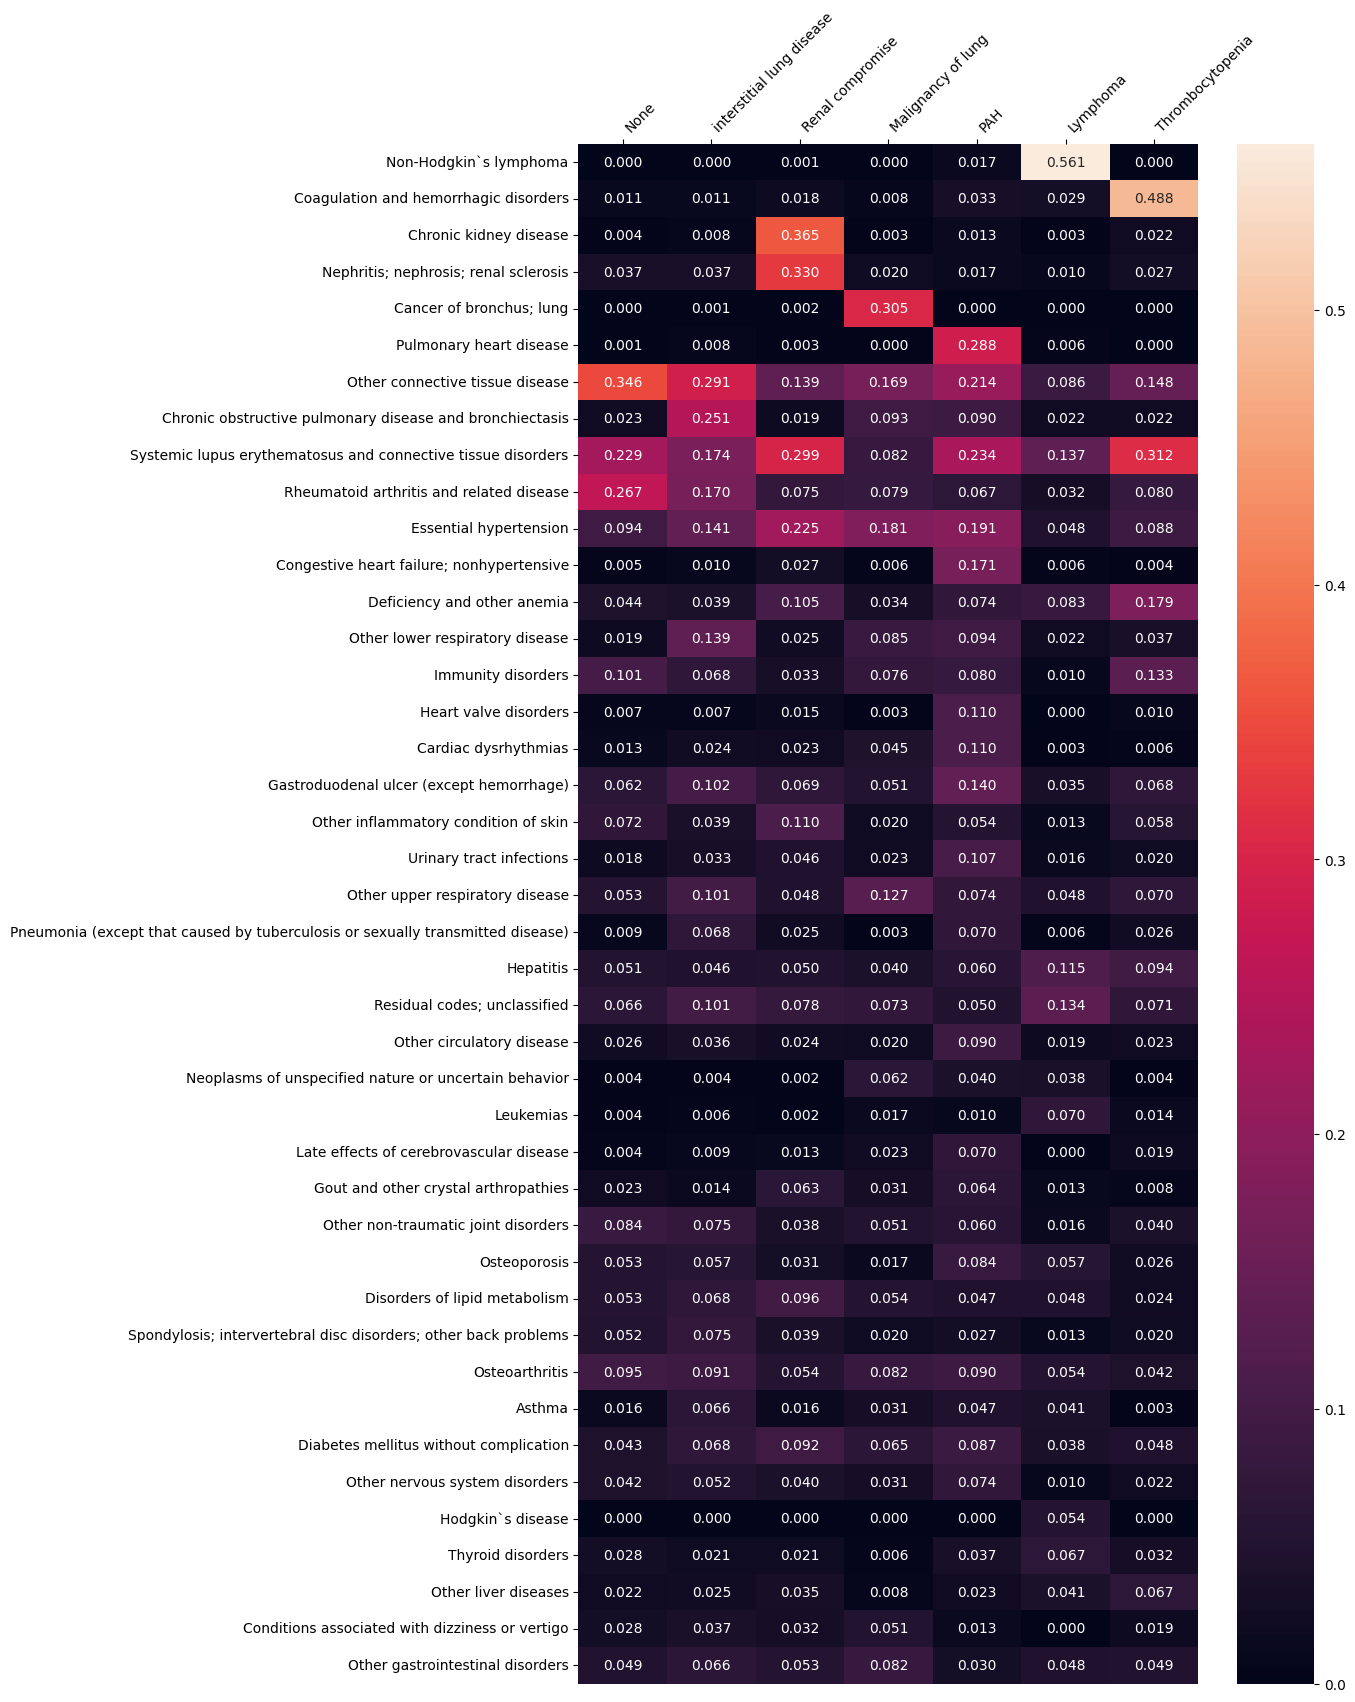

In [ ]:
diff_ccs_sample = draw_plt(ehr_cluster_ccs_mean, ehr_cluster_ccs_std, n, ccs_name)

/tmp/ipykernel_1825172/1573139222.py:26: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (class_1_probs - class_2_probs) / SE_diff


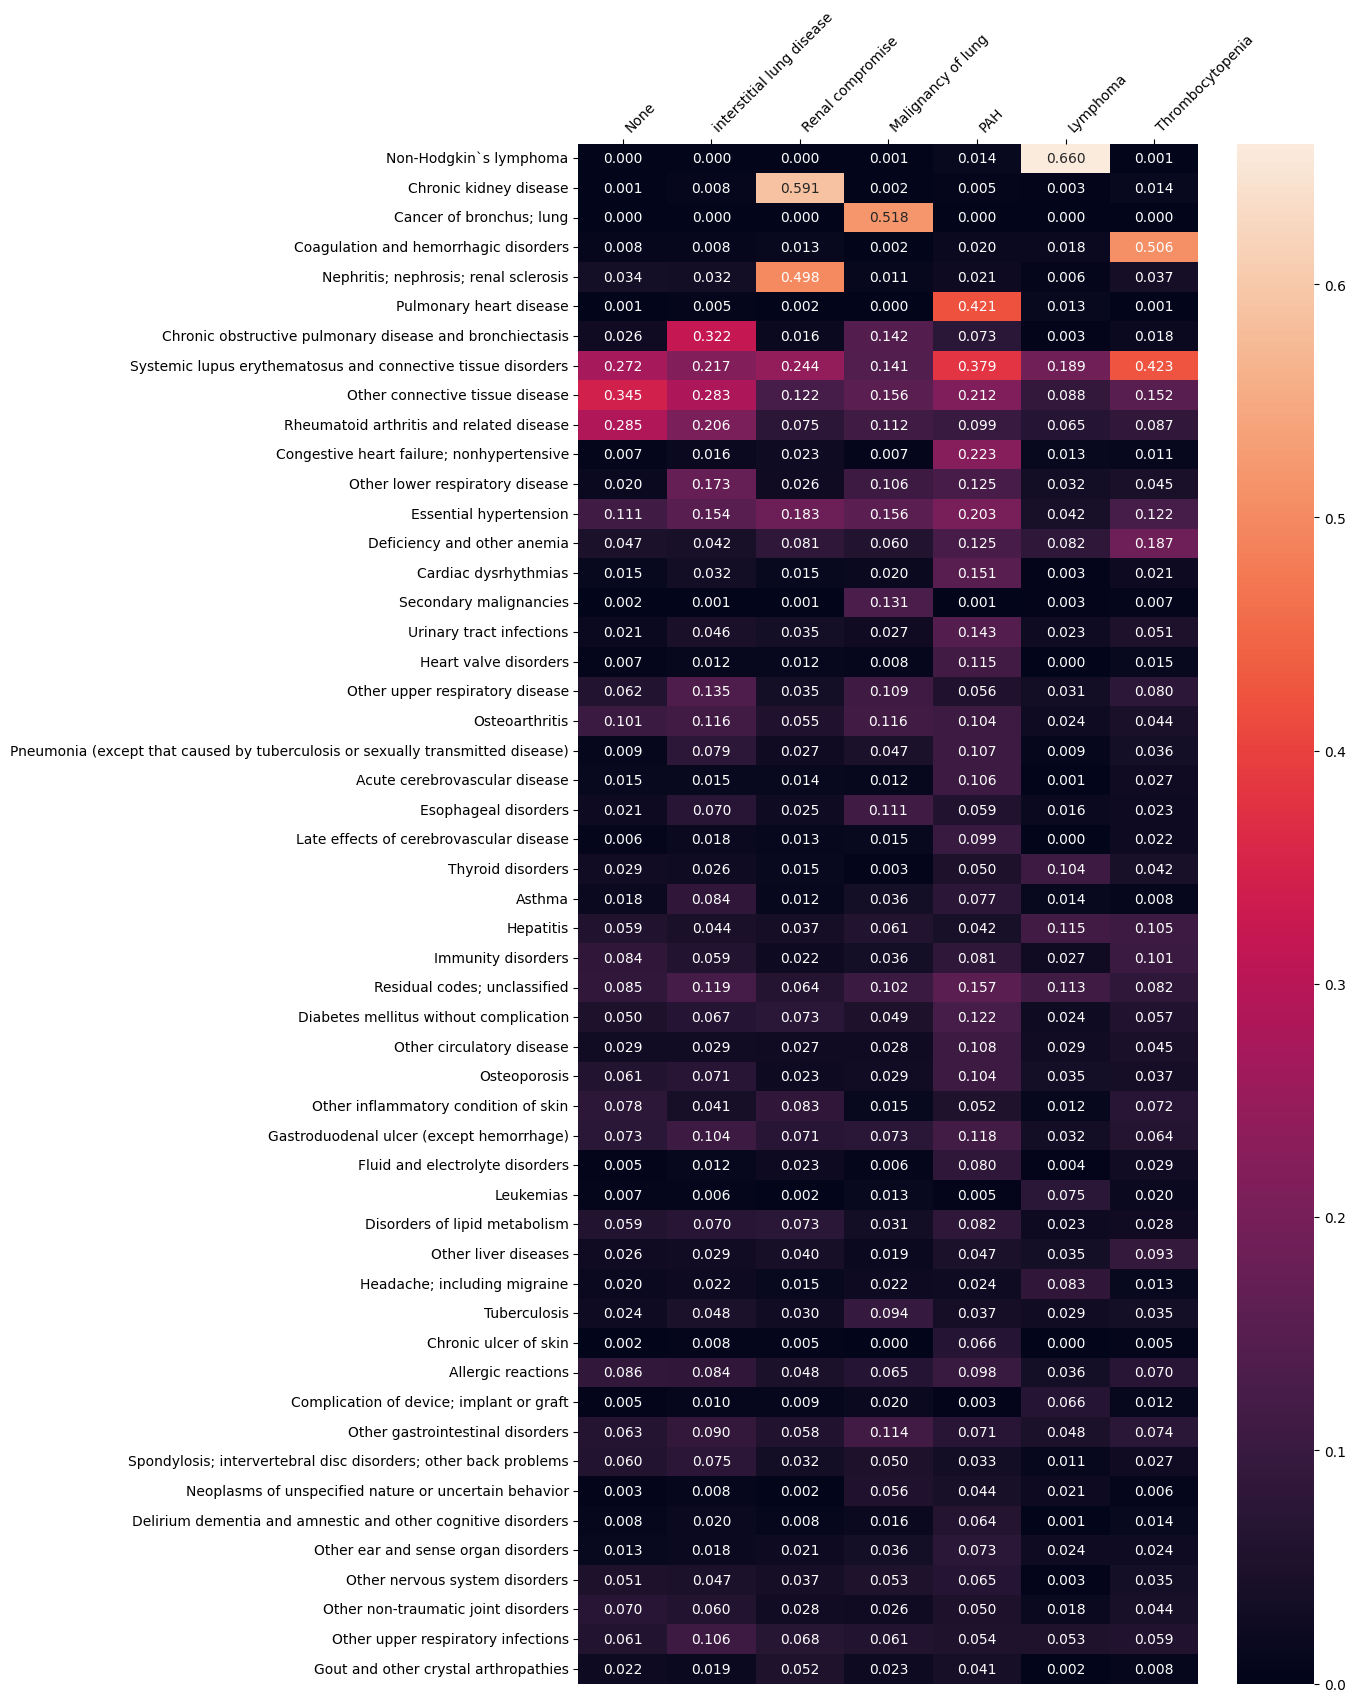

In [ ]:
diff_ccs = draw_plt(ehr_cluster_ccs_mean, ehr_cluster_ccs_std, n, ccs_name)

In [ ]:
set(diff_ccs) - set(diff_ccs_sample)

{'Acute cerebrovascular disease',
 'Allergic reactions',
 'Chronic ulcer of skin',
 'Complication of device; implant or graft',
 'Delirium dementia and amnestic and other cognitive disorders',
 'Esophageal disorders',
 'Fluid and electrolyte disorders',
 'Headache; including migraine',
 'Other ear and sense organ disorders',
 'Other upper respiratory infections',
 'Secondary malignancies',
 'Tuberculosis'}

In [ ]:
set(diff_ccs_sample) - set(diff_ccs)

{'Conditions associated with dizziness or vertigo', 'Hodgkin`s disease'}